## Начало 1-й лабораторной работы по мии в этом семаке, еее 

### Перечислим атрибуты датасета

name - Название или обозначение астероида.

absolute_magnitude - Абсолютная звездная величина астероида.

estimated_diameter_min - Минимальный оценочный диаметр астероида (в километрах).

estimated_diameter_max - Максимальный оценочный диаметр астероида (в километрах).

hazardous - Является ли астероид потенциально опасным.

relative_velocity - Относительная скорость астероида по отношению к Земле (в километрах в секунду).

miss_distance - Расстояние между Землёй и астероидом в момент его максимального сближения.

orbiting_body - Центральное небесное тело, вокруг которого движется астероид.

sentry_object - Указывает, отслеживается ли данный объект системой мониторинга NASA Sentry.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

df = pd.read_csv(".//static//csv//neo.csv")
df = df.head(30000)
print(df.head())

        id                 name  est_diameter_min  est_diameter_max  \
0  2162635  162635 (2000 SS164)          1.198271          2.679415   
1  2277475    277475 (2005 WK4)          0.265800          0.594347   
2  2512244   512244 (2015 YE18)          0.722030          1.614507   
3  3596030          (2012 BV13)          0.096506          0.215794   
4  3667127          (2014 GE35)          0.255009          0.570217   

   relative_velocity  miss_distance orbiting_body  sentry_object  \
0       13569.249224   5.483974e+07         Earth          False   
1       73588.726663   6.143813e+07         Earth          False   
2      114258.692129   4.979872e+07         Earth          False   
3       24764.303138   2.543497e+07         Earth          False   
4       42737.733765   4.627557e+07         Earth          False   

   absolute_magnitude  hazardous  
0               16.73      False  
1               20.00       True  
2               17.83      False  
3               22.20   

### Выбирем входные и выходные переменные

* Входные переменные - переменные-факторы, влияющие на целевую переменную
* Выходная переменная - целевая перменная, для которой будет строиться нечеткая система

Применительно к нашей задаче:

* Входные переменные: estimated_diameter_max(максимальный оценочный диаметр астреоида) и relative_velocity(скорость относительно Земли)
* Выходные переменные: miss_distance(минимальное расстояние до Земли)

### Настроим параметры лингвистических переменных

##### 1. Термы (нечеткие термы)
Термы — лингвистические значения, которые описывают возможные состояния нечеткой переменной. Они используются для качественного описания значений переменной, например:

* Для переменной "Температура" термы могут быть: "холодно", "тепло", "горячо".
* Для переменной "Скорость" термы могут быть: "медленно", "средне", "быстро".

Каждый терм связан с функцией принадлежности, которая определяет, насколько значение переменной соответствует этому терму.

##### 2. Функция принадлежности
Функция принадлежности (membership function) — математическая функция, которая определяет степень принадлежности элемента к нечеткому множеству. Она возвращает значение от 0 до 1, где:

* 0 — элемент точно не принадлежит множеству.

* 1 — элемент точно принадлежит множеству.

Значения между 0 и 1 — частичная принадлежность.

Функция принадлежности задается для каждого терма.

##### 3. Параметры функции принадлежности
Параметры функции принадлежности — числа, которые определяют форму и положение функции на числовой оси. Форма функции зависит от выбранного типа (например, треугольная, трапециевидная, гауссова). 

##### В нашем случае:

Термы: 
* Маленький (Small) 
* Средний (Medium) 
* Большой (Large)

Параметры:

Маленький (Small):
* Нижняя граница: 0 
* Средняя граница: 250 
* Верхняя граница: 500

Средний (Medium): 
* Нижняя граница: 400
* Средняя граница: 1000
* Верхняя граница: 2000

Большой (Large): 
* Нижняя граница: 1800
* Средняя граница: 5000
* Верхняя граница: 10000

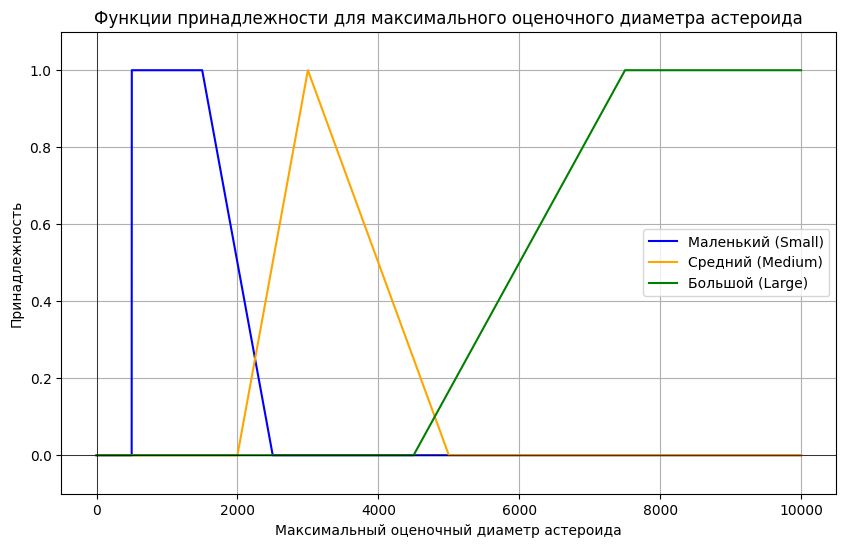

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz

volume_range = np.arange(0, 10000, 1)

# Определение функций принадлежности для термов

small = fuzz.trapmf(volume_range, [500, 500, 1500, 2500])

medium = fuzz.trimf(volume_range, [2000, 3000, 5000])

large = fuzz.trapmf(volume_range, [4500, 7500, 10000, 10000])

# Визуализация функций принадлежности
plt.figure(figsize=(10, 6))
plt.plot(volume_range, small, label='Маленький (Small)', color='blue')
plt.plot(volume_range, medium, label='Средний (Medium)', color='orange')
plt.plot(volume_range, large, label='Большой (Large)', color='green')
plt.title('Функции принадлежности для максимального оценочного диаметра астероида')
plt.xlabel('Максимальный оценочный диаметр астероида')
plt.ylabel('Принадлежность')
plt.ylim(-0.1, 1.1)
plt.axhline(0, color='black', lw=0.5)
plt.axvline(0, color='black', lw=0.5)
plt.legend()
plt.grid()

plt.show()

### Формируем базу нечетких правил

Нечеткие правила (fuzzy rules) — основа нечетких систем вывода, которые используются для моделирования сложных, нечетко определенных процессов. Эти правила позволяют описать взаимосвязь между входными и выходными переменными в терминах лингвистических значений (термов).

Нечеткие правила:
Если Цена открытия Низкая И Объем Низкий, Тогда Цена закрытия Низкая.
Если Цена открытия Низкая И Объем Средний, Тогда Цена закрытия Средняя.
Если Цена открытия Низкая И Объем Высокий, Тогда Цена закрытия Средняя.
Если Цена открытия Средняя И Объем Низкий, Тогда Цена закрытия Средняя.
Если Цена открытия Средняя И Объем Средний, Тогда Цена закрытия Высокая.
Если Цена открытия Средняя И Объем Высокий, Тогда Цена закрытия Высокая.
Если Цена открытия Высокая И Объем Низкий, Тогда Цена закрытия Средняя.
Если Цена открытия Высокая И Объем Средний, Тогда Цена закрытия Высокая.
Если Цена открытия Высокая И Объем Высокий, Тогда Цена закрытия Высокая.


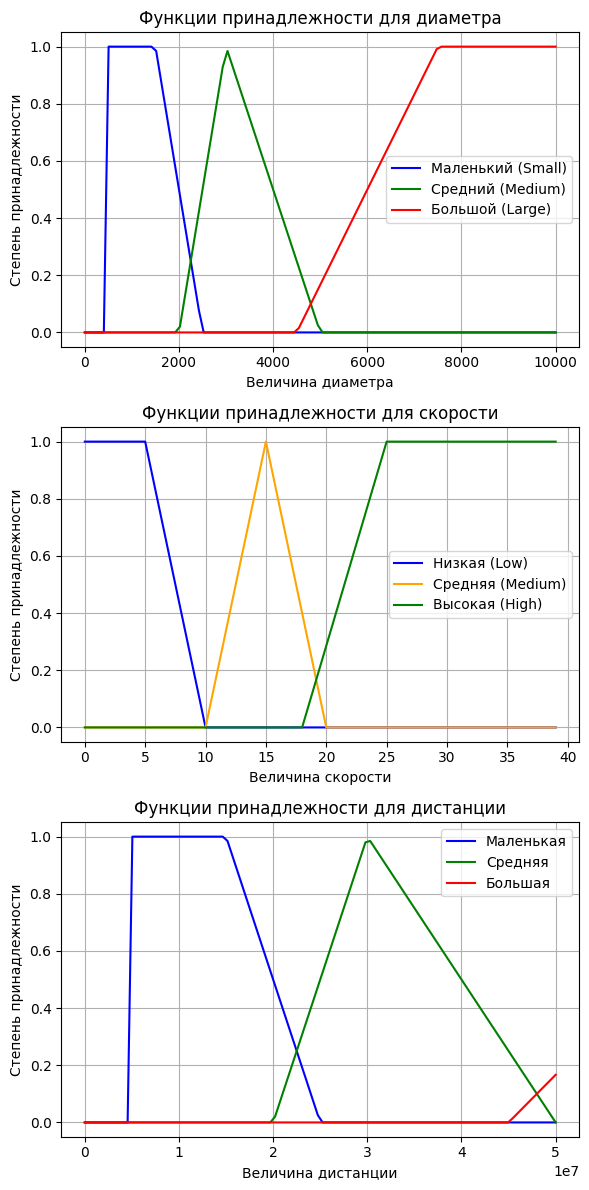

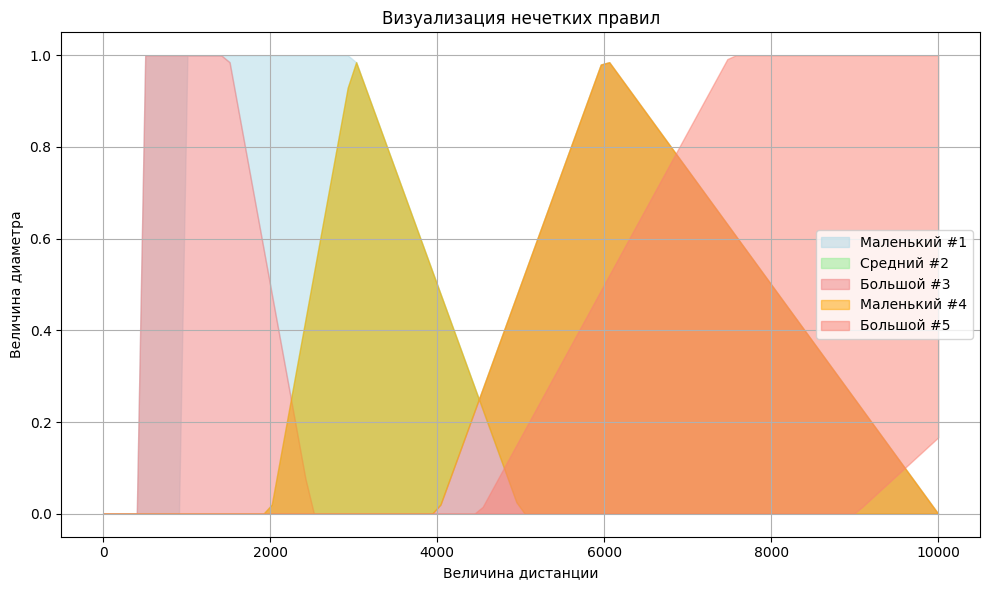

In [12]:
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt

# Определяем диапазоны значений для входных переменных
x_diameter = np.linspace(0, 10000, 100) 
x_velocity = np.arange(0, 40, 1)   
x_distance = np.linspace(0, 50000000, 100) 

# Определение функций принадлежности для диаметра
low_diameter = fuzz.trapmf(x_diameter, [500, 500, 1500, 2500])
medium_diameter = fuzz.trimf(x_diameter, [2000, 3000, 5000])
high_diameter = fuzz.trapmf(x_diameter, [4500, 7500, 10000, 10000])

# Определение функций принадлежности для скорости
low_velocity = fuzz.trapmf(x_velocity, [0, 0, 5, 10])
medium_velocity = fuzz.trimf(x_velocity, [10, 15, 20])
high_velocity = fuzz.trapmf(x_velocity, [18, 25, 40, 40])

# Определение функций принадлежности для цены дистанции
low_distance = fuzz.trapmf(x_distance, [5000000, 5000000, 15000000, 25000000])
medium_distance = fuzz.trimf(x_distance, [20000000, 30000000, 50000000])
high_distance = fuzz.trapmf(x_distance, [45000000, 75000000, 100000000, 100000000])

# Определение нечетких правил
fuzzy_rules = [
    ("Низкая", "Низкий", "Низкая"),
    ("Низкая", "Средний", "Средняя"),
    ("Низкая", "Высокий", "Средняя"),
    ("Средняя", "Низкий", "Средняя"),
    ("Средняя", "Средний", "Высокая"),
    ("Средняя", "Высокий", "Высокая"),
    ("Высокая", "Низкий", "Средняя"),
    ("Высокая", "Средний", "Высокая"),
    ("Высокая", "Высокий", "Высокая"),
]

print("Нечеткие правила:")
for rule in fuzzy_rules:
    print(f"Если Цена открытия {rule[0]} И Объем {rule[1]}, Тогда Цена закрытия {rule[2]}.")

# Визуализация функций принадлежности
fig, axs = plt.subplots(3, 1, figsize=(6, 12))

axs[0].plot(x_diameter, low_diameter, label='Маленький (Small)', color='blue')
axs[0].plot(x_diameter, medium_diameter, label='Средний (Medium)', color='green')
axs[0].plot(x_diameter, high_diameter, label='Большой (Large)', color='red')
axs[0].set_title('Функции принадлежности для диаметра')
axs[0].set_xlabel('Величина диаметра')
axs[0].set_ylabel('Степень принадлежности')
axs[0].legend()
axs[0].grid()

axs[1].plot(x_velocity, low_velocity, label='Низкая (Low)', color='blue')
axs[1].plot(x_velocity, medium_velocity, label='Средняя (Medium)', color='orange')
axs[1].plot(x_velocity, high_velocity, label='Высокая (High)', color='green')
axs[1].set_title('Функции принадлежности для скорости')
axs[1].set_xlabel('Величина скорости')
axs[1].set_ylabel('Степень принадлежности')
axs[1].legend()
axs[1].grid()

axs[2].plot(x_distance, low_distance, label='Маленькая', color='blue')
axs[2].plot(x_distance, medium_distance, label='Средняя', color='green')
axs[2].plot(x_distance, high_distance, label='Большая', color='red')
axs[2].set_title('Функции принадлежности для дистанции')
axs[2].set_xlabel('Величина дистанции')
axs[2].set_ylabel('Степень принадлежности')
axs[2].legend()
axs[2].grid()

plt.tight_layout()
plt.show()

# Визуализация нечетких правил
fig, ax = plt.subplots(figsize=(10, 6))

# Пример нечеткого вывода для визуализации
for rule in fuzzy_rules:
    if rule[0] == "Низкая" and rule[1] == "Низкий":
        ax.fill_between(x_diameter, low_diameter, low_distance, color='lightblue', alpha=0.5, label='Маленький #1')
    elif rule[0] == "Низкая" and rule[1] == "Средний":
        ax.fill_between(x_diameter, medium_diameter, medium_distance, color='lightgreen', alpha=0.5, label='Средний #2')
    elif rule[0] == "Низкая" and rule[1] == "Высокий":
        ax.fill_between(x_diameter, low_diameter, medium_distance, color='lightcoral', alpha=0.5, label='Большой #3')
    elif rule[0] == "Средняя" and rule[1] == "Низкий":
        ax.fill_between(x_diameter, medium_diameter, medium_distance, color='orange', alpha=0.5, label='Маленький #4')
    elif rule[0] == "Высокая" and rule[1] == "Высокий":
        ax.fill_between(x_diameter, high_diameter, high_distance, color='salmon', alpha=0.5, label='Большой #5')

ax.set_title('Визуализация нечетких правил')
ax.set_xlabel('Величина дистанции')
ax.set_ylabel('Величина диаметра')
ax.legend()
ax.grid()

plt.tight_layout()
plt.show()

### Оценим качество полученной нечеткой системы с помощью метрик регрессии

In [16]:
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt

# Определяем диапазоны значений для входных переменных
x_diameter = np.linspace(0, 10000, 100) 
x_velocity = np.arange(0, 40, 1)   
x_distance = np.linspace(0, 50000000, 100) 

# Определение функций принадлежности для диаметра
low_diameter = fuzz.trapmf(x_diameter, [500, 500, 1500, 2500])
medium_diameter = fuzz.trimf(x_diameter, [2000, 3000, 5000])
high_diameter = fuzz.trapmf(x_diameter, [4500, 7500, 10000, 10000])

# Определение функций принадлежности для скорости
low_velocity = fuzz.trapmf(x_velocity, [0, 0, 5, 10])
medium_velocity = fuzz.trimf(x_velocity, [10, 15, 20])
high_velocity = fuzz.trapmf(x_velocity, [18, 25, 40, 40])

# Определение функций принадлежности для цены дистанции
low_distance = fuzz.trapmf(x_distance, [5000000, 5000000, 15000000, 25000000])
medium_distance = fuzz.trimf(x_distance, [20000000, 30000000, 50000000])
high_distance = fuzz.trapmf(x_distance, [45000000, 75000000, 100000000, 100000000])

# Создаем тестовые данные
test_data = [
    (1500, 10, 0),
    (5000, 25, 40330398), 
    (8000, 15, 35000000),
    (4000, 35, 100000000), 
]

# Функция для вычисления нечеткой оценки
def fuzzy_inference(open_price, volume):
    # Определяем степень принадлежности
    open_low = fuzz.interp_membership(x_diameter, low_diameter, open_price)
    open_medium = fuzz.interp_membership(x_diameter, medium_diameter, open_price)
    open_high = fuzz.interp_membership(x_diameter, high_diameter, open_price)

    volume_low = fuzz.interp_membership(x_velocity, low_velocity, volume)
    volume_medium = fuzz.interp_membership(x_velocity, medium_velocity, volume)
    volume_high = fuzz.interp_membership(x_velocity, high_velocity, volume)

    # Применяем правила
    close_low = np.fmin(open_low, volume_low)
    close_medium = np.fmin(open_medium, volume_medium)
    close_high = np.fmin(open_high, volume_high)

    # Вычисление выходных значений с учетом ненулевых областей
    close0 = fuzz.defuzz(x_distance, low_distance * close_low, 'centroid') if close_low > 0 else 0
    close1 = fuzz.defuzz(x_distance, medium_distance * close_medium, 'centroid') if close_medium > 0 else 0
    close2 = fuzz.defuzz(x_distance, high_distance * close_high, 'centroid') if close_high > 0 else 0

    return max(close0, close1, close2)

# Список для хранения результатов
results = []

# Оценка системы на тестовом наборе данных
for open_price, volume, actual_close in test_data:
    inferred_close = fuzzy_inference(open_price, volume)
    results.append((open_price, volume, actual_close, inferred_close))

# Вывод результатов с более структурированным оформлением
print(f"{'Величина диаметра':<18} | {'Величина скорости':<10} | {'Фактическая величина дистанции':<30} | {'Полученная величина дистанции':<30}")
print("=" * 92)  # Строка-разделитель

for open_price, volume, actual_close, inferred_close in results:
    print(f"{open_price:<18} | {volume:<10} | {actual_close:<30} | {inferred_close:<30.2f}")

# Вычисление метрик качества
actual_closes = [actual for _, _, actual, _ in results]
inferred_closes = [inferred for _, _, _, inferred in results]

mae = np.mean(np.abs(np.array(actual_closes) - np.array(inferred_closes)))
rmse = np.sqrt(np.mean((np.array(actual_closes) - np.array(inferred_closes)) ** 2))

print(f"\nСредняя абсолютная ошибка (MAE): {mae:.2f}")
print(f"Среднеквадратичная ошибка (RMSE): {rmse:.2f}")


Величина диаметра  | Величина скорости | Фактическая величина дистанции | Полученная величина дистанции 
1500               | 10         | 0                              | 0.00                          
5000               | 25         | 40330398                       | 48330398.79                   
8000               | 15         | 35000000                       | 0.00                          
4000               | 35         | 100000000                      | 0.00                          

Средняя абсолютная ошибка (MAE): 35750000.20
Среднеквадратичная ошибка (RMSE): 53124852.97


Даже если учесть немалый объем данных и большие принимаемые значения переменных, в с связи с которыми метрики ошибок приняли немаленькие значения, результат можно охарактеризовать как не самый точный 